# Initiate random dataset

In [173]:
import random
from faker import Factory

### Simulation parameters

MAX_REPO_COMMIT_COUNT = 4000
MAX_PUSH_COMMIT_COUNT = 10
NUMBER_OF_REPOS = 200
NUMBER_OF_USERS = 50
NUMBER_OF_PUSHS = 1000
NUMBER_OF_SCORING = 450
AVERALL_AVERAGE_RATE = 0.7

faker = Factory.create()

# repos are mapped by id
repos = {}
# users are mapped by id
users = {}

print "Generating repos ..."
for i in range(0, NUMBER_OF_REPOS):
    repos[str(i)] = {
        'id': i, 
        'repo_name': faker.domain_word(), 
        'ratings': {},
        'score': -1,
        'commit_count': 0,
        'contributors': {}
    }
print "-> %d repos generated" % len(repos.keys())


print "Generating users ..."
for i in range(0, NUMBER_OF_USERS):
    users[str(i)] = {
        'id': i, 
        'username': faker.user_name(), 
        'karma': 1, # at first, everyone has the same karma
        'contributions': {}, # key id of the repository, value number of contributions
        'ratings': {}
    }
print "-> %d users generated" % len(users.keys())
    
    
print "Generating contributions ..."
total_commit_count = 0
for i in range(0, NUMBER_OF_PUSHS ):
    contrib_repo_id = str(random.randint(0, NUMBER_OF_REPOS - 1))
    contrib_user_id = str(random.randint(0, NUMBER_OF_USERS - 1))
    contrib_commit_count = random.randint(1, MAX_PUSH_COMMIT_COUNT - 1)
    
    if repos[contrib_repo_id]['commit_count'] + contrib_commit_count < MAX_REPO_COMMIT_COUNT:
        repos[contrib_repo_id]['commit_count'] += contrib_commit_count
        total_commit_count += contrib_commit_count
        
        # Mapping contributions from user to repos
        if contrib_repo_id in users[contrib_user_id]['contributions']:
            users[contrib_user_id]['contributions'][contrib_repo_id] += contrib_commit_count
        else:
            users[contrib_user_id]['contributions'][contrib_repo_id] = contrib_commit_count
        
        # Mapping contributions from repos to users
        if contrib_user_id in repos[contrib_repo_id]['contributors']:
            repos[contrib_repo_id]['contributors'][contrib_user_id] += contrib_commit_count
        else:
            repos[contrib_repo_id]['contributors'][contrib_user_id] = contrib_commit_count
print "-> %d commits generated" % total_commit_count

Generating repos ...
-> 200 repos generated
Generating users ...
-> 50 users generated
Generating contributions ...
-> 5065 commits generated


In [174]:
#the biggest the number of commit the highest the chance of being rated

repos_pd = pd.DataFrame.from_dict(repos, orient='index')
repos_pd.sort(['commit_count'], ascending=[0], inplace=True)

def get_weighted_random_repo_id():
    from math import log
    beta = NUMBER_OF_REPOS / ( 10 * log(2)) # median around NUMBER_OF_REPOS / 10
    return repos_pd.index[min(np.random.exponential(beta), NUMBER_OF_REPOS-1)]

def biaised_rate(rates):
    if rates == []:
        return np.random.binomial(5, AVERALL_AVERAGE_RATE)
    else:
        return np.random.binomial(5, np.mean(rates)/5.1)
    
def scoreRepo(userId, repoId, rating):
    if rating['doc'] is None or rating['code_quality'] is None or rating['support'] is None:
        print "Can't vote, missing one argument"
    else:
        # Basic implementation of scoring algorithm
        repos[repoId]['ratings'][userId] = rating
        if repos[repoId]['score'] == -1:
            repos[repoId]['score'] = (rating['doc'] + rating['code_quality'] + rating['support']) / 3
        else:
            repos[repoId]['score'] = (repos[repoId]['score'] + users[userId]['karma'] * (rating['doc'] + rating['code_quality'] + rating['support']) / 3) / (2 + users[userId]['karma'])
        propagateScoreChange(repoId)
        
def propagateScoreChange(repoId):
    currentRepo = repos[repoId]
    for userId, contributions in repos[repoId]['contributors'].iteritems():
        # Basic implementation of propagation algorithm
        users[userId]['karma'] = ( users[userId]['karma'] + (contributions / currentRepo['commit_count']) * currentRepo['score']) / 2
        
    
print "Generating scores ..."
total_scoring_count = 0
for i in range(0, NUMBER_OF_SCORING):
    scoring_repo_id = get_weighted_random_repo_id()
    scoring_user_id = random.choice(repos[scoring_repo_id]['contributors'].keys())
    
    ratings = repos[scoring_repo_id]['ratings'].itervalues()
    arguments = ['doc', 'support', 'code_quality']
    rating ={arg: biaised_rate([r[arg] for r in ratings]) for arg in arguments}

    scoreRepo(scoring_user_id, scoring_repo_id, rating)
    total_scoring_count += 1

Generating scores ...


# Info plots on the generated dataset

## Contributions distribution

In [175]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

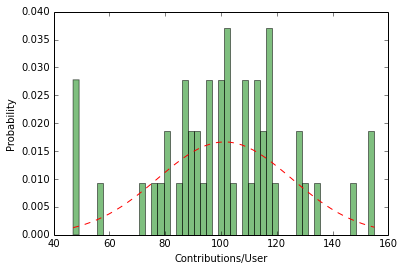

In [176]:
contributions = []

for user_id, user in users.iteritems():

    acc = 0
    for repo_id, contribs in user['contributions'].iteritems():
        acc += contribs
    
    contributions.append(acc)

n, bins, patches = plt.hist(contributions, 50, normed=1, facecolor='green', alpha=0.5)

mu = np.mean(contributions)
sigma = np.std(contributions)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, '--r')
plt.xlabel('Contributions/User')
plt.ylabel('Probability')
plt.show()

## Karma Distribution

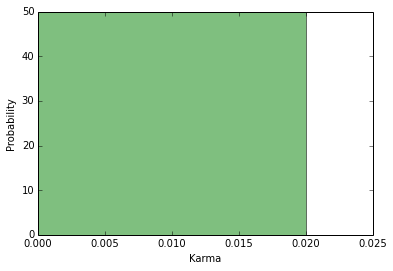

In [177]:
karmas = []

for user_id, user in users.iteritems():
    karmas.append(user['karma'])

n, bins, patches = plt.hist(karmas, 50, normed=1, facecolor='green', alpha=0.5)

mu = np.mean(karmas)
sigma = np.std(karmas)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, '--r')
plt.xlabel('Karma')
plt.ylabel('Probability')
plt.show()

## Score Distribution

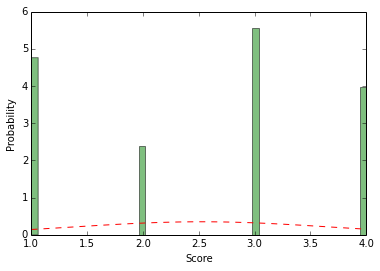

In [181]:
scores = []

for repo_id, repo in repos.iteritems():
    if repo['score'] > 0:
        scores.append(repo['score'])

n, bins, patches = plt.hist(scores, 50, normed=1, facecolor='green', alpha=0.5)

mu = np.mean(scores)
sigma = np.std(scores)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, '--r')
plt.xlabel('Score')
plt.ylabel('Probability')
plt.show()

# 